# Multi-label Image Classification using Pretrained VGG16 Model

This notebook outlines an approach to a multi-label image classification problem encompassing six classes, by leveraging the power of Transfer Learning with the pre-trained VGG16 model.

**Transfer Learning with VGG16**: This method utilizes the robust VGG16 model, pre-trained on the extensive ImageNet dataset. Through Transfer Learning, we can harness the feature extraction capabilities of VGG16 to our specific problem, significantly enhancing performance and accuracy, especially when dealing with a relatively smaller dataset.

**ImageDataGenerator for data handling**: The dataset for this project comprises images falling under six distinct classes. The data is structured as a single folder with all images and a CSV file containing zero-shot encoded values and IDs of the images. We utilize Keras's ImageDataGenerator for efficient image loading, pre-processing, and  fast data augmentation, providing more diverse training data and improving model generalization. ImageDataGenerator also splits the data into training and validation sets for model evaluation.

## Importing the necessary libraries

In [56]:
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import keras
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv

## Loading CSV

In [43]:
# read the CSV file
df = pd.read_csv('dataset_5_small.csv')

df.head()


,id,glasses,hand,mask,none,other,sunglasses
0,i00001.jpg,1,0,0,0,0,0
1,i00002.jpg,1,0,0,0,0,0
2,i00003.jpg,1,0,0,0,0,0
3,i00004.jpg,1,0,0,0,0,0
4,i00005.jpg,1,1,0,0,0,0


In [44]:
# Convert 'id' column to strings
df['id'] = df['id'].astype(str)


In [45]:
#number of classes
num_classes=6

## Dataset

In [46]:
import csv
import os

# Create a ImageDataGenerator instance for image normalization, augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest"
)

# Image directory path
image_directory = 'dataset'

# Generate data for training and validation
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_directory,
    x_col='id',
    y_col=['glasses', 'hand', 'mask', 'none', 'other', 'sunglasses'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_directory,
    x_col='id',
    y_col=['glasses', 'hand', 'mask', 'none', 'other', 'sunglasses'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    subset='validation'
)

Found 9497 validated image filenames.
Found 2374 validated image filenames.


## Model Structure

In [47]:
# Define the directory to save the models
save_dir = "./saved_models_multi-label"
os.makedirs(save_dir, exist_ok=True)

# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the weights of the pre-trained layers
base_model.trainable = False

# Create a ModelCheckpoint callback to save the model
checkpoint_template = os.path.join(save_dir, "model_epoch{epoch:02d}.h5")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_template, save_freq="epoch")

# Create the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Display the model summary
model.summary()






Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 18,912,582
Trainable params: 4,197,894
Non-trainable params: 14,714,688
_________________________________________________________________


## Train the model

In [48]:
#set epochs number
epochs_num = 20

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs_num,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
296/296 [==============================] - 71s 236ms/step - loss: 0.1621 - accuracy: 0.8348 - val_loss: 0.7736 - val_accuracy: 0.2437
Epoch 2/20
296/296 [==============================] - 67s 227ms/step - loss: 0.1159 - accuracy: 0.8733 - val_loss: 0.7666 - val_accuracy: 0.2378
Epoch 3/20
296/296 [==============================] - 69s 233ms/step - loss: 0.1060 - accuracy: 0.8814 - val_loss: 0.7094 - val_accuracy: 0.2660
Epoch 4/20
296/296 [==============================] - 70s 235ms/step - loss: 0.0993 - accuracy: 0.8868 - val_loss: 0.6815 - val_accuracy: 0.2711
Epoch 5/20
296/296 [==============================] - 69s 235ms/step - loss: 0.0964 - accuracy: 0.8895 - val_loss: 0.7259 - val_accuracy: 0.2551
Epoch 6/20
296/296 [==============================] - 68s 229ms/step - loss: 0.0959 - accuracy: 0.8918 - val_loss: 0.7942 - val_accuracy: 0.2703
Epoch 7/20
296/296 [==============================] - 67s 225ms/step - loss: 0.0903 - accuracy: 0.8949 - val_loss: 0.6532 - val_ac

In [49]:
# Save the model
model.save('model_VGG16_multi-label.h5')

## Plotting the model performance over epochs

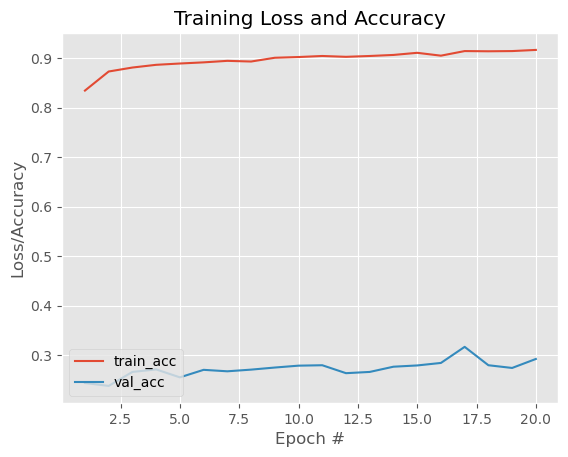

In [50]:
# plot the training loss and accuracy
N = epochs_num+1
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluationVGG_multilabel_small_DataAugmentation.png')

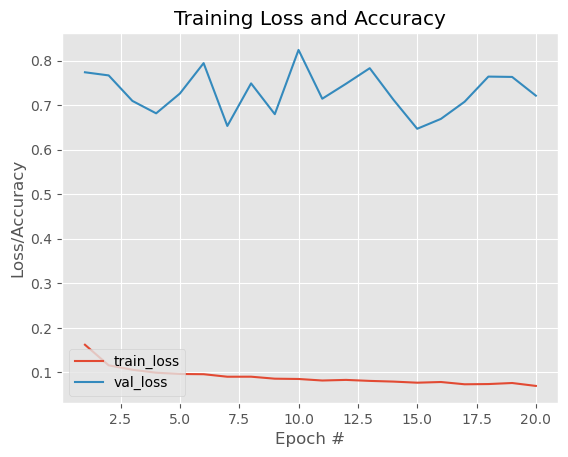

In [51]:
# plot the training loss
N = epochs_num+1
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(1, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluationVGG_multilabel_small_DataAugmentation.png')

### From this graph, it can be seen that propably the best model would be epoch 7
### It has the lowest validation loss of 0.6532 or epoch 17, which has highest validation accuracy of 0.3167.
### Still it seems that the model generalizes the data much worse than the binary single-label classifier and does not improve with time

### Template for loading the model

In [54]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('./saved_models_multi-label/model_epoch17.h5')

## Template for classifying a test image

1/1 [==============================] - 0s 18ms/step


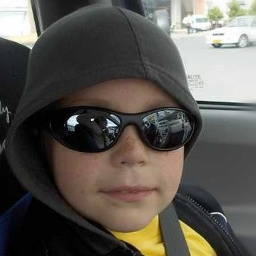

The model predicts this image is a: sunglasses


In [57]:
# Load the image
img_path = 'test.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Preprocess the image
input_arr = image.img_to_array(img)
input_arr = np.array([input_arr])

# Make the prediction
predictions = loaded_model.predict(input_arr)

display(Image(filename=img_path))
        

# Decode the prediction
class_names = ['glasses', 'hand', 'mask', 'none', 'other', 'sunglasses']  # order of labels may vary based on your dataset, ensure the correct order
predicted_class = class_names[np.argmax(predictions)]
print("The model predicts this image is a:", predicted_class)


## Template for classifying a test image #2


In [68]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the image
img_path = 'test.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Convert the image to a numpy array
x = image.img_to_array(img)

# Add a dimension to match the model's input shape
x = np.expand_dims(x, axis=0)

# Preprocess the image
x = preprocess_input(x)

# Use the model to make a prediction
predictions = loaded_model.predict(x)

# Since this is a multi-label classification, each label will have a separate probability
# We can consider labels with probability > 0.5 as active
predicted_labels = predictions[0]

# Get the labels from the dataframe
labels = df.columns[1:]  # we skip the first column which is 'id'

# Create a dictionary mapping the labels to the predictions
label_predictions = dict(zip(labels, predicted_labels))

# Print the label predictions
for label, prediction in label_predictions.items():
    print(f"{label}: {prediction}")


1/1 [==============================] - 0s 17ms/step
glasses: 0.0
hand: 0.0
mask: 0.0
none: 0.0
other: 0.0
sunglasses: 1.0
